In [20]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda
import datetime

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [105]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map_wind(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(12,7), dpi=200)  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        qk = plt.quiverkey(qu, 0.9, 0.03, 4, '4 m s$^{-1}$',
                           labelpos='E', coordinates='figure')
        
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.tight_layout()
    plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/conny_examples/850hpa_rh_ERA5_peru.png')

In [ ]:
def draw_map(t, lat, lon):
    f=plt.figure(figsize=(15,10))
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree())
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.colorbar()
    plt.show()

In [64]:
hour = '/media/ck/Elements/SouthAmerica/ERA5/hourly/pressure_levels/ERA5_2018_11_19_pl.nc'

dat = xr.open_dataset(hour)

In [65]:
dat

<xarray.Dataset>
Dimensions:    (latitude: 77, level: 17, longitude: 101, time: 8)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -57.5 -57.25 -57.0
  * latitude   (latitude) float32 1.0 0.75 0.5 0.25 ... -17.5 -17.75 -18.0
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
  * time       (time) datetime64[ns] 2018-11-19 ... 2018-11-19T21:00:00
Data variables:
    d          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    pv         (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-11 09:41:28 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [66]:
dat = uda.flip_lat(dat)

In [67]:
dat['time.hour'].values==12

array([False, False, False, False,  True, False, False, False])

In [68]:
shour = dat.sel(time=(dat['time.hour']==12))

In [69]:
#shour = dat.sel(time=datetime.time(12))

In [70]:
shour = shour.squeeze()

In [71]:
shour

<xarray.Dataset>
Dimensions:    (latitude: 77, level: 17, longitude: 101)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -57.5 -57.25 -57.0
  * latitude   (latitude) float32 -18.0 -17.75 -17.5 -17.25 ... 0.5 0.75 1.0
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
    time       datetime64[ns] 2018-11-19T12:00:00
Data variables:
    d          (level, latitude, longitude) float32 ...
    z          (level, latitude, longitude) float32 ...
    pv         (level, latitude, longitude) float32 ...
    r          (level, latitude, longitude) float32 ...
    q          (level, latitude, longitude) float32 ...
    t          (level, latitude, longitude) float32 ...
    u          (level, latitude, longitude) float32 ...
    v          (level, latitude, longitude) float32 ...
    w          (level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-11 09:41:28 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [102]:
# preparation of wind vector data in plot
st=4
sarrow = 2
xquiv = shour.longitude[sarrow::st]
yquiv = shour.latitude[sarrow::st]

uu = (shour['u'].sel(level=850).values)[sarrow::st, sarrow::st]
vv = (shour['v'].sel(level=850).values)[sarrow::st, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 80}

In [73]:
contour = {'data' : shour['u'].sel(level=850), 'x' : lon, 'y' : lat, 'levels' : [-5,-2,-1,-0.5,0.5,1,2,5], 'cmap' : 'RdBu'}


NameError: name 'lon' is not defined

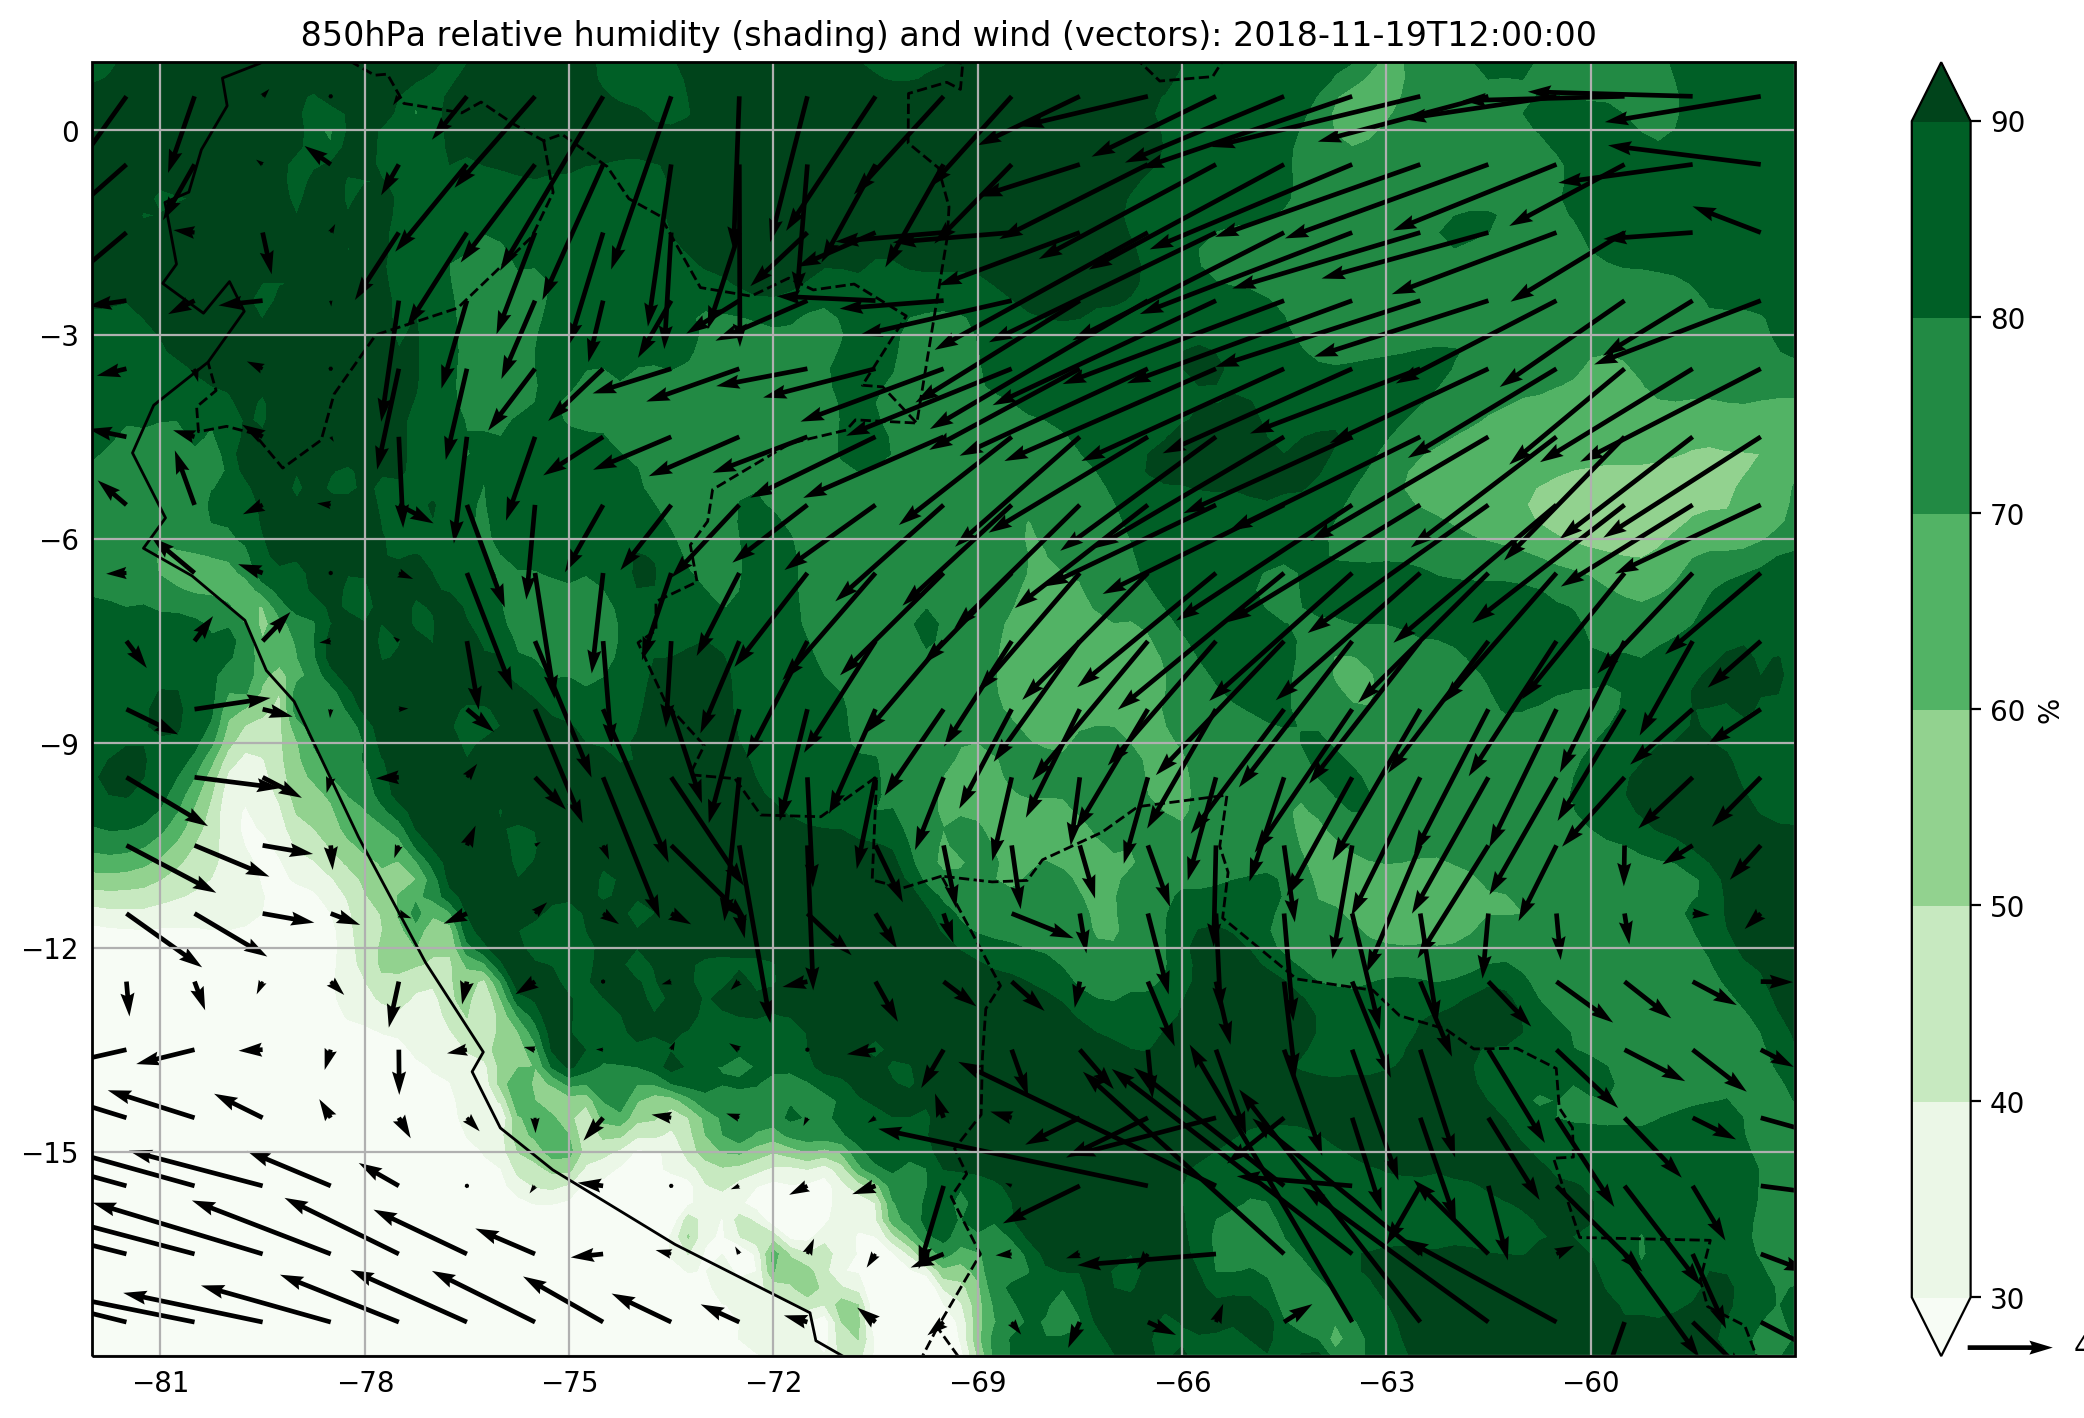

In [106]:
draw_map_wind(shour['r'].sel(level=850), shour.longitude, shour.latitude, title=' 850hPa relative humidity (shading) and wind (vectors): 2018-11-19T12:00:00',  quiver=qin, contour=None, cbar_label='%', cmap='Greens', levels=[30,40,50,60,70,80,90], extend='both')


In [21]:
# make salem grid
grid = u_grid.make(mdic['lon'].values, mdic['lat'].values, 5000)
inds, weights, shape = u_int.interpolation_weights_grid(mdic['lon'].values, mdic['lat'].values, grid)
gridd = (inds,weights,shape, grid)


In [22]:
outt = u_int.interpolate_data(mdic['t'].values, inds, weights, shape)

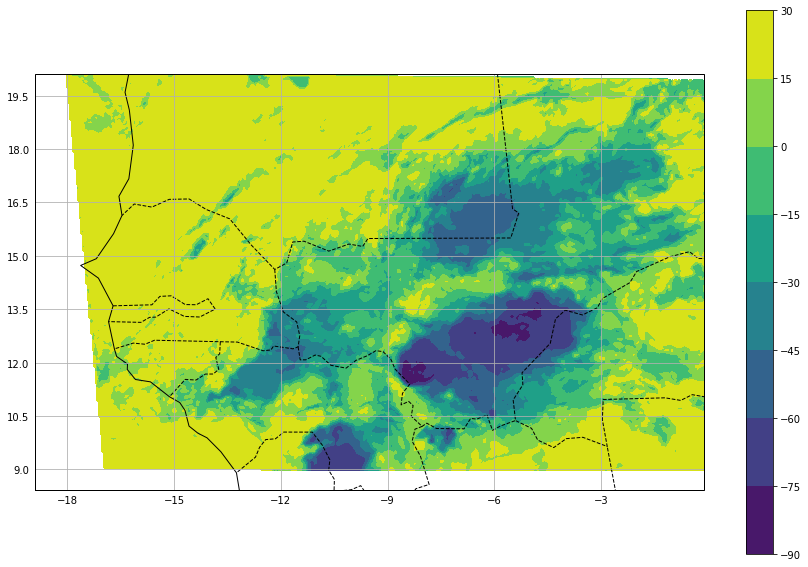

In [30]:
draw_map(outt, grid.ll_coordinates[1], grid.ll_coordinates[0])

In [27]:
grid.ll_coordinates

(array([[-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323],
        [-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323],
        [-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323],
        ...,
        [-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323],
        [-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323],
        [-18.06906891, -18.02415314, -17.97923738, ...,  -0.19259475,
          -0.14767899,  -0.10276323]]),
 array([[ 8.93017387,  8.93017387,  8.93017387, ...,  8.93017387,
          8.93017387,  8.93017387],
        [ 8.97483424,  8.97483424,  8.97483424, ...,  8.97483424,
          8.97483424,  8.97483424],
        [ 9.01948904,  9.01948904,  9.01948904, ...,  9.01948904,
          9.01948904,  9.01948904],
        ...,
        [20.026321